## Model Building and Evaluation

In this document I will build and evaluate a few machine learning models for lead service line prediction. After a train/test split I will oversample the minority (lead) train various machine learning models to maximize the F1 statistic. F1 is the harmonic mean of the precision and recall of the model. I chose this metric so the model can efficiently allocate funding for service line replacement (higher precision) while not sacrificing public health (higher recall).

In the effort to optimize F1, I first try logistic regression and random forest classifier with 5-fold cross validation.

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sklearn
from shapely.geometry import multipolygon
import shapely.wkt
import geopandas


Read in the clean dataset.

In [3]:
#Data too big to push to github.
lead_data = pd.read_csv('insight/Cross_val_model_set_with_income_feb5.csv')
lead_data.shape

(604182, 21)

Create dummy variables of categorical data.

In [5]:
#lead_data = t
#Create dummy variables
dummy_cityowned = pd.get_dummies(lead_data['CityOwned'],prefix='city')
dummy_zip = pd.get_dummies(lead_data['zip'], prefix='zip')
dummy_taxclass = pd.get_dummies(lead_data['taxclass'],prefix='tax')

dummy_taxclass.drop('tax_1',inplace=True,axis=1)
dummy_cityowned.drop('city_No', inplace=True, axis=1)
dummy_zip.drop('zip_10002', inplace=True, axis=1)
all_dummy = pd.concat([dummy_taxclass,dummy_cityowned, dummy_zip], axis=1)
lead_data_dummies = pd.concat([lead_data, all_dummy], axis=1)


Here I will split the data into test and training set. I will then oversample the lead class in the training set. Note that the technique used below will be to oversample first, and then perform 5-fold cross validation. In the future I would look to oversample within each iteration of the cross validation.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

lead_data_train, lead_data_test = train_test_split(lead_data_dummies, test_size=0.2)
dummy_names = list(all_dummy.columns)
tax_names = list(dummy_taxclass.columns)
zip_names = list(dummy_zip.columns)
city_names = list(dummy_cityowned.columns)

#features = ['Construction Year','fullval','bldfront','blddepth', 'GROUNDELEV','Lead_Index_tenth'] + tax_names + city_names
#features = ['Construction Year','Lead_Index_tenth','Lead_Index_quarter','bldfront','blddepth', 'GROUNDELEV'] +city_names + tax_names

features = ['Construction Year', 'Lead_Index_quarter','bldfront','blddepth',
            'GROUNDELEV', 'Median_Income','nn_diff']+ city_names+tax_names

#Separate classes
lead = lead_data_train[lead_data_train['Pipe Material'] == 1]
no_lead = lead_data_train[lead_data_train['Pipe Material'] == 0]

#Upsample lead
lead_upsample = resample(lead, replace=True, n_samples=no_lead.shape[0]) 
 
#Combine the upsampled lead with no lead data
lead_upsample = pd.concat([no_lead, lead_upsample])
 

X_train = lead_upsample[features]
Y_train = lead_upsample['Pipe Material']
X_test = lead_data_test[features]
Y_test = lead_data_test['Pipe Material']


Now I will write a few functions to help in the model evaluation stage. The first prints the accuracy score for the model and classification report containing precision, recall, and F1. The second plots the ROC curve for different decision thresholds of the model as well as the ROC curve for a dummy classifier that predicts at the stratified rate.

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.dummy import DummyClassifier




def model_evaluation(model, X_test, y_test, model_type):
    
    pred = model.predict(X_test)
    cm = confusion_matrix(Y_test, pred)
    print('Accuracy of ' + model_type + ' on test set: {:.2f}'.format(model.score(X_test, Y_test)))
    print('Classification report for ' + model_type)
    print(classification_report(Y_test,pred))
    
def plot_roc(model, X_test, Y_test, model_type):

    # Create dummy classifier to predict along the class imbalance.
    dummy_clf = DummyClassifier(strategy="stratified")
    dummy_clf.fit(X_test, Y_test)
    dummy_prob = dummy_clf.predict(X_test)

    # Generate predictions from the model
    model_prob = model.predict_proba(X_test)

    # keep probabilities for the lead (positive) outcome only
    model_prob = model_prob[:, 1]

    # calculate area under ROC curves
    dummy_auc = roc_auc_score(Y_test, dummy_prob)
    model_auc = roc_auc_score(Y_test, model_prob)
    
    # print scores
    print('No Skill: ROC AUC=%.3f' % (dummy_auc))
    print('Logistic: ROC AUC=%.3f' % (model_auc))

    # calculate roc curves. fpr = false positive rate, tpr = true positive rate.
    dummy_fpr, dummy_tpr, _ = roc_curve(Y_test, dummy_prob)
    model_fpr, model_tpr, _ = roc_curve(Y_test, model_prob)
    
    # plot the roc curves for both the model and dummy classifier
    pyplot.plot(dummy_fpr, dummy_tpr, linestyle='--', label='Dummy Classifier')
    pyplot.plot(model_fpr, model_tpr, marker='.', label=model_type)
    
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    
    # show the legend
    pyplot.legend()
    
    # show the plot
    pyplot.show()

Here I begin the model building with a logistic regression. 

In [26]:
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



logreg = LogisticRegression()
#logreg.fit(X_train,Y_train)
scores = cross_validate(logreg, X_train, Y_train, cv=5, scoring = ('precision','recall','f1','roc_auc'))
print(scores)


C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


{'fit_time': array([ 9.05280781, 13.22441649, 10.72484994, 11.54937744, 10.96471167]), 'score_time': array([0.55068421, 0.55368161, 0.53569293, 0.5946579 , 0.52969575]), 'test_precision': array([0.56996752, 0.69009502, 0.66368935, 0.63395083, 0.66180382]), 'train_precision': array([0.56959325, 0.68966523, 0.66255205, 0.63461439, 0.66288836]), 'test_recall': array([0.64619388, 0.78108988, 0.74757152, 0.73973901, 0.74029942]), 'train_recall': array([0.64837746, 0.78081707, 0.7452006 , 0.73877916, 0.74190815]), 'test_f1': array([0.60569184, 0.73277837, 0.70313755, 0.68277153, 0.69885437]), 'train_f1': array([0.60643728, 0.73241601, 0.70145019, 0.6827466 , 0.70017583]), 'test_roc_auc': array([0.59513037, 0.78839541, 0.75330636, 0.70478916, 0.74682832]), 'train_roc_auc': array([0.59416523, 0.78820887, 0.75107096, 0.70539769, 0.74884054])}


Now we will evaluate the logistic regression on the test set. And print the evaluation metrics and ROC curve

In [30]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Accuracy of Logistic Regression on test set: 0.54
Classification report for Logistic Regression
             precision    recall  f1-score   support

          0       0.83      0.50      0.63     93878
          1       0.27      0.65      0.38     26959

avg / total       0.71      0.54      0.57    120837

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.590


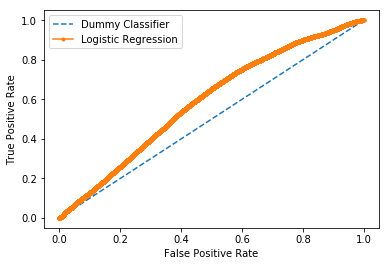

In [31]:
model_evaluation(logreg,X_test,Y_test, 'Logistic Regression')

plot_roc(logreg, X_test, Y_test, 'Logistic Regression')

I will now train random forest classifier. First I will see the validation scores using a 5-fold split. Then I will tune hyperparameters to optimize F1.

In [21]:
##### CROSS VAL RF
from sklearn.model_selection import KFold


rf=RandomForestClassifier(n_estimators =35)
scores = cross_validate(rf, X_train, Y_train, cv=5, scoring = ('precision','recall','f1','roc_auc'))
print(scores)


{'fit_time': array([112.30859041, 130.99887586, 121.58927107, 109.6031425 ,
       103.40569687]), 'score_time': array([23.76037431, 15.84091711, 15.50710773, 14.71955872, 14.79851341]), 'test_precision': array([0.87914715, 0.87999422, 0.87817643, 0.88000626, 0.87702029]), 'train_precision': array([0.99949972, 0.9995264 , 0.99950973, 0.99949973, 0.99942974]), 'test_recall': array([0.97677802, 0.97562994, 0.97640401, 0.97623051, 0.97623051]), 'train_recall': array([0.99990324, 0.9999266 , 0.99991992, 0.99991659, 0.9999266 ]), 'test_f1': array([0.92539465, 0.92534763, 0.92468892, 0.92562433, 0.92396989]), 'train_f1': array([0.99970144, 0.99972646, 0.99971479, 0.99970811, 0.99967811]), 'test_roc_auc': array([0.98511356, 0.98535695, 0.9851205 , 0.98514969, 0.98518944]), 'train_roc_auc': array([0.99999887, 0.99999883, 0.99999892, 0.99999888, 0.99999893])}


Next I will use 5-fold cross validation to tune hyperparameters to optimize F1. First I will establish a grid in the hyperparameter space on which to perform a random search. The best configuration of hyperparameters for 5-fold cross validation will be printed 

In [16]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
weight = ['balanced']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': weight}
print(random_grid)

{'n_estimators': [100, 150, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'class_weight': ['balanced']}


In [ ]:
# Use the random grid to search for best hyperparameters

rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, scoring = 'f1', param_distributions = random_grid, n_iter = 20, cv = 5, verbose=3, random_state=42, n_jobs = -1)
# Fit the random  search model
rf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [18]:
rf_best = rf_random.best_estimator_
rf_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'class_weight': 'balanced',
 'bootstrap': True}

Accuracy of Random Forest (Best) on test set: 0.82
Classification report for Random Forest (Best)
             precision    recall  f1-score   support

          0       0.88      0.89      0.88     93878
          1       0.60      0.59      0.59     26959

avg / total       0.82      0.82      0.82    120837

No Skill: ROC AUC=0.502
Logistic: ROC AUC=0.871


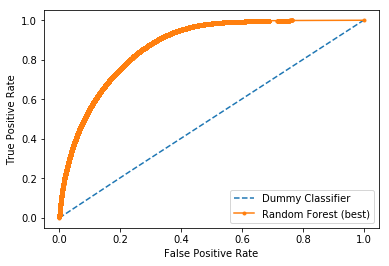

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#Train best model
rf_best=RandomForestClassifier(n_estimators =150, min_samples_split=5, min_samples_leaf=1,
                               max_features='auto', max_depth=None, class_weight='balanced', bootstrap=True)
rf_best.fit(X_train,Y_train)

model_evaluation(rf_best,X_test,Y_test, 'Random Forest (Best)')
plot_roc(rf_best, X_test, Y_test, 'Random Forest (best)')

In [33]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


rf_base=RandomForestClassifier(n_estimators =10, class_weight='balanced')

rf_base.fit(X_train,Y_train)
y_pred_base = rf_base.predict(X_test)


Accuracy of Random Forest (Base) on test set: 0.81
Classification report for Random Forest (Base)
             precision    recall  f1-score   support

          0       0.87      0.90      0.88     93878
          1       0.59      0.52      0.55     26959

avg / total       0.81      0.81      0.81    120837

No Skill: ROC AUC=0.498
Logistic: ROC AUC=0.846


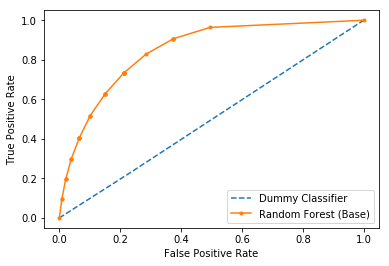

In [34]:
model_evaluation(rf_base,X_test,Y_test, 'Random Forest (Base)')
plot_roc(rf_base, X_test, Y_test, 'Random Forest (Base)')

Accuracy of Naive Bayes Classifier on test set: 0.55
Classification report for Naive Bayes Classifier
             precision    recall  f1-score   support

          0       0.96      0.44      0.61     93878
          1       0.33      0.93      0.48     26959

avg / total       0.82      0.55      0.58    120837

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.756


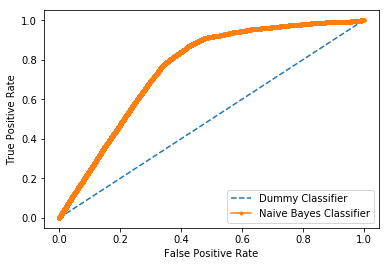

In [44]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train,Y_train)
predictions_gnb = gnb.predict(X_test)

model_evaluation(gnb, X_test, Y_test, 'Naive Bayes Classifier')

plot_roc(gnb, X_test, Y_test, 'Naive Bayes Classifier')

No Skill: ROC AUC=0.498
RF (best): ROC AUC=0.871
RF (base): ROC AUC=0.846
Logistic (base): ROC AUC=0.590
Naive Bayes (base): ROC AUC=0.756


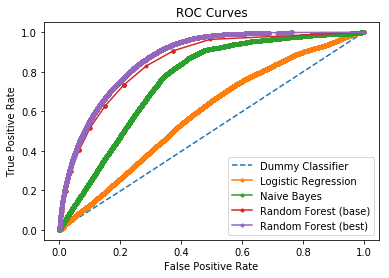

In [43]:

# Create dummy classifier to predict along the class imbalance.
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_test, Y_test)
dummy_prob = dummy_clf.predict(X_test)



# Generate predictions from the rf_best_
rf_best_prob = rf_best.predict_proba(X_test)
rf_base_prob = rf_base.predict_proba(X_test)
logreg_prob = logreg.predict_proba(X_test)
gnb_prob = gnb.predict_proba(X_test)

# keep probabilities for the lead (positive) outcome only
rf_best_prob = rf_best_prob[:, 1]
rf_base_prob = rf_base_prob[:, 1]
logreg_prob = logreg_prob[:, 1]
gnb_prob = gnb_prob[:, 1]

# calculate area under ROC curves
dummy_auc = roc_auc_score(Y_test, dummy_prob)
rf_best_auc = roc_auc_score(Y_test, rf_best_prob)
rf_base_auc = roc_auc_score(Y_test, rf_base_prob)
gnb_auc = roc_auc_score(Y_test, gnb_prob)
          
# print scores
print('No Skill: ROC AUC=%.3f' % (dummy_auc))
print('RF (best): ROC AUC=%.3f' % (rf_best_auc))
print('RF (base): ROC AUC=%.3f' % (rf_base_auc))
print('Logistic (base): ROC AUC=%.3f' % (logreg_auc))
print('Naive Bayes (base): ROC AUC=%.3f' % (gnb_auc))

# calculate roc curves. fpr = false positive rate, tpr = true positive rate.
dummy_fpr, dummy_tpr, _ = roc_curve(Y_test, dummy_prob)
rf_best_fpr, rf_best_tpr, _ = roc_curve(Y_test, rf_best_prob)
rf_base_fpr, rf_base_tpr, _ = roc_curve(Y_test, rf_base_prob)
logreg_fpr, logreg_tpr, _ = roc_curve(Y_test, logreg_prob)
gnb_fpr, gnb_tpr, _ = roc_curve(Y_test, gnb_prob)
            
# plot the roc curves for both the rf_best_ and dummy classifier
pyplot.plot(dummy_fpr, dummy_tpr, linestyle='--', label='Dummy Classifier')
pyplot.plot(logreg_fpr, logreg_tpr, marker='.', label='Logistic Regression')
pyplot.plot(gnb_fpr, gnb_tpr, marker='.', label='Naive Bayes')
pyplot.plot(rf_base_fpr, rf_base_tpr, marker='.', label='Random Forest (base)')
pyplot.plot(rf_best_fpr, rf_best_tpr, marker='.', label='Random Forest (best)')


    
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curves')   
#pyplot.figure(figsize =(15,15))
# show the legend
pyplot.legend()
    
# show the plot
pyplot.show()

Accuracy of base RF classifier on test set: 0.81
[[87121  6377]
 [16070 11269]]
             precision    recall  f1-score   support

          0       0.84      0.93      0.89     93498
          1       0.64      0.41      0.50     27339

avg / total       0.80      0.81      0.80    120837

No Skill: ROC AUC=0.500
Random Forest (Base Model): ROC AUC=0.841
Random Forest (Best Model): ROC AUC=0.873


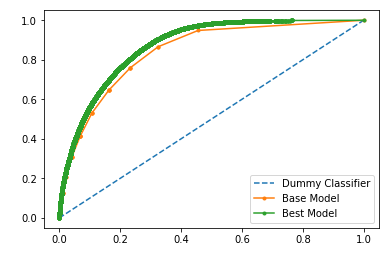

<Figure size 1080x1080 with 0 Axes>

In [32]:


#no skill prob
ns_probs = [0 for _ in range(len(X_test))]
rf_base_probs = rf_base.predict_proba(X_test)
rf_best_probs = rf_best.predict_proba(X_test)

# keep probabilities for the positive outcome only
rf_base_probs = rf_base_probs[:, 1]
rf_best_probs = rf_best_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
rf_base_auc = roc_auc_score(Y_test, rf_base_probs)
rf_best_auc = roc_auc_score(Y_test, rf_best_probs)
log_best_auc = roc_auc_score(Y_test, rf_best_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest (Base Model): ROC AUC=%.3f' % (rf_base_auc))
print('Random Forest (Best Model): ROC AUC=%.3f' % (rf_best_auc))
print('Logistic Regression (Base Model): ROC AUC=%.3f' % (log_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
rf_base_fpr, rf_base_tpr, _ = roc_curve(Y_test, rf_base_probs)
rf_best_fpr, rf_best_tpr, _ = roc_curve(Y_test, rf_best_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Dummy Classifier')
pyplot.plot(rf_base_fpr, rf_base_tpr, marker='.', label='Base Model')
pyplot.plot(rf_best_fpr, rf_best_tpr, marker='.', label='Best Model')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
pyplot.figure(figsize =(15,15))
# show the plot
pyplot.show()


# Naive Bayes

Accuracy of Naive Bayes Classifier on test set: 0.55
Classification report for Naive Bayes Classifier
             precision    recall  f1-score   support

          0       0.96      0.44      0.61     93878
          1       0.33      0.93      0.48     26959

avg / total       0.82      0.55      0.58    120837

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.756


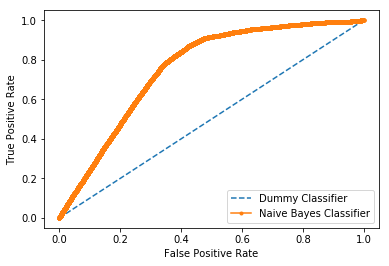

Random forest feature importance.

Feature ranking:
1. feature 6 (0.240355)
2. feature 0 (0.235953)
3. feature 1 (0.175176)
4. feature 4 (0.108750)
5. feature 3 (0.085159)
6. feature 5 (0.078247)
7. feature 2 (0.065990)
8. feature 8 (0.005201)
9. feature 9 (0.004427)
10. feature 7 (0.000741)


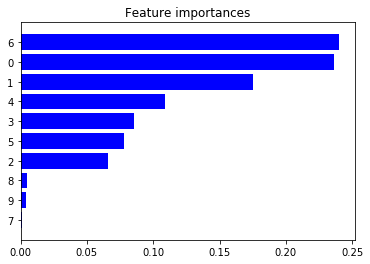

In [53]:
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="b", align="center")
plt.yticks(range(X_train.shape[1]), indices)
plt.ylim([-1, X_train.shape[1]])
plt.gca().invert_yaxis()
plt.show()